In [1]:
#@title Importaciones

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#@title importacion de archivos y formateo de columnas

anime_dataset = pd.read_csv("./anime.csv", sep = '\t',on_bad_lines='skip')

anime_dataset.columns = anime_dataset.columns.str.lower()
anime_dataset.columns = anime_dataset.columns.str.replace(' ', '_')

In [3]:
anime_dataset = anime_dataset[anime_dataset['anime_id'] != 44303] # anime que cumple con los 200 caracteres en synopsis pero no contiene datos utiles para su estudio
anime_dataset_filt = pd.DataFrame(anime_dataset[ anime_dataset["synopsis"].str.len() >= 200 ])
anime_dataset_filt = anime_dataset_filt.sort_values(by='popularity_rank')
anime_dataset_filt.index = range(0,len(anime_dataset_filt)) 

In [7]:
#@title Eliminando columnas

col_delete_list = ["score","score_count", "score_rank","type", "status", "num_episodes", "start_date",
                   "end_date", "season", "studios", "clubs", "score_01_count",
                   "score_02_count", "score_03_count", "score_04_count", "score_05_count",
                   "score_06_count", "score_07_count", "score_08_count", "score_09_count",
                   "score_10_count", "num_episodes", "watching_count",
                   "completed_count","on_hold_count","dropped_count"]

filter_columns = list(filter(lambda x: True if x not in col_delete_list else False, list(anime_dataset_filt.columns)))

anime_dataset_filt = anime_dataset_filt[filter_columns]


anime_dataset_filt['longitud_synopsis_caracteres'] = anime_dataset_filt['synopsis'].apply(len) 
#anime_dataset_filt['genres'] = anime_dataset_filt['genres'].apply(lambda x: x.split('|'))

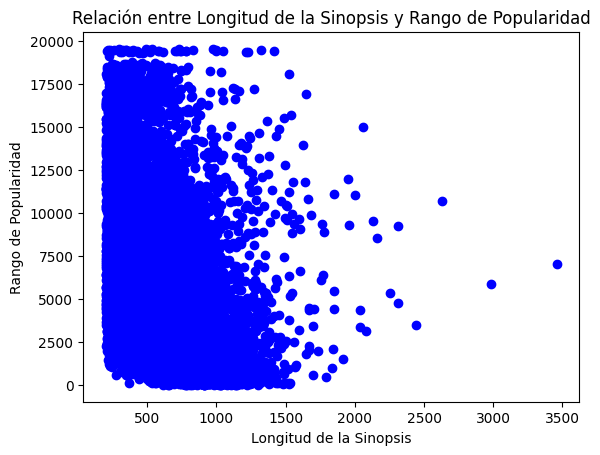

In [8]:
data_generos = pd.DataFrame(list(set(elemento for sublista in anime_dataset_filt['genres'] for elemento in sublista)), columns=['genres'])
data_generos["genres_ID"] = list( Id for Id in range(0,len(data_generos)))

mapa_nombres_a_ids = dict(zip(data_generos['genres'], data_generos['genres_ID'])) # diccionario conde la clave es el "nombre" del genero y el valor el "id"

anime_dataset_filt['genres'] = anime_dataset_filt['genres'].apply(lambda lista: [mapa_nombres_a_ids[elemento] for elemento in lista]) # remplaza los nombres de los generos por el ID



df_generos_count = anime_dataset_filt.explode('genres') # expande anime_dataset_filt para dividir las listas en filas individuales


df_generos_count = df_generos_count.groupby('genres').size().reset_index(name='cantidad') # Agrupamos por el género y contamos la cantidad de animes en cada uno
df_generos_count.columns = ['genres_ID', 'cantidad'] 

data_generos = pd.merge(data_generos, df_generos_count, on='genres_ID', how='left') # une la cantidad de anime con segun el genero 




correlacion_longSynop_populRank = anime_dataset_filt[['longitud_synopsis_caracteres', 'popularity_rank']].corr()



# MUESTRAR EL GRAFICO PARA VER QUE MIENTRAS MAS LARGA LA SINOPSIS MÁS PROBABILIDAD TIENE DE QUE ESTÉ MEJOR RANKEADA


plt.scatter(anime_dataset_filt['longitud_synopsis_caracteres'], anime_dataset_filt['popularity_rank'], color='blue')
plt.title('Relación entre Longitud de la Sinopsis y Rango de Popularidad')
plt.xlabel('Longitud de la Sinopsis')
plt.ylabel('Rango de Popularidad')
plt.show()




In [10]:
data_generos

,genres,genres_ID,cantidad
0,Action,0,2567
1,Psychological,1,287
2,Hentai,2,822
3,Mecha,3,641
4,Parody,4,282
5,Demons,5,337
6,Shoujo,6,473
7,Boys Love,7,116
8,Drama,8,1688
9,Avant Garde,9,134
